# Spatial trajectory inference analysis tutorial

In this tutorial, we are using both spatial information and gene expression profile to perform spatial trajectory inference to explore the progression of Ductal Carcinoma in situ (DCIS) - Invasive Ductal Cancer (IDC)

## 1. Preparation

We are trying to keep it focus on spatial trajectory inference then every step from reading data to clustering, we will give the code here to easier for user to use

In [1]:
import stlearn as st
data = st.Read10X(path="../UQ/10X/BCBA/")

st.pp.filter_genes(data,min_cells=3)
st.pp.normalize_total(data)
st.pp.log1p(data)
st.pp.scale(data)
st.em.run_pca(data,n_comps=50,random_state=0)
st.pp.tiling(data,out_path="../tiling",crop_size = 40)
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data="X_pca",radius=50,method="mean")



D:\Anaconda3\envs\stlearn\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|███████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Extract feature: 100%|████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|█████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_pca_morphology']


In [2]:
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology',random_state=0)

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


In [3]:
st.tl.clustering.louvain(data,random_state=0)

Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']


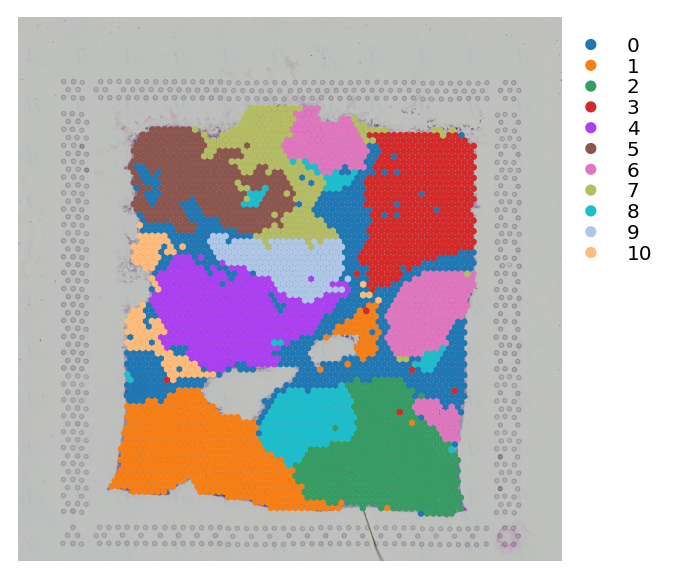

In [4]:
st.pl.cluster_plot(data,use_label="louvain",tissue_alpha=1,spot_size=7,show_legend=True)

The annotation is added to adata.obs['louvain_anno']


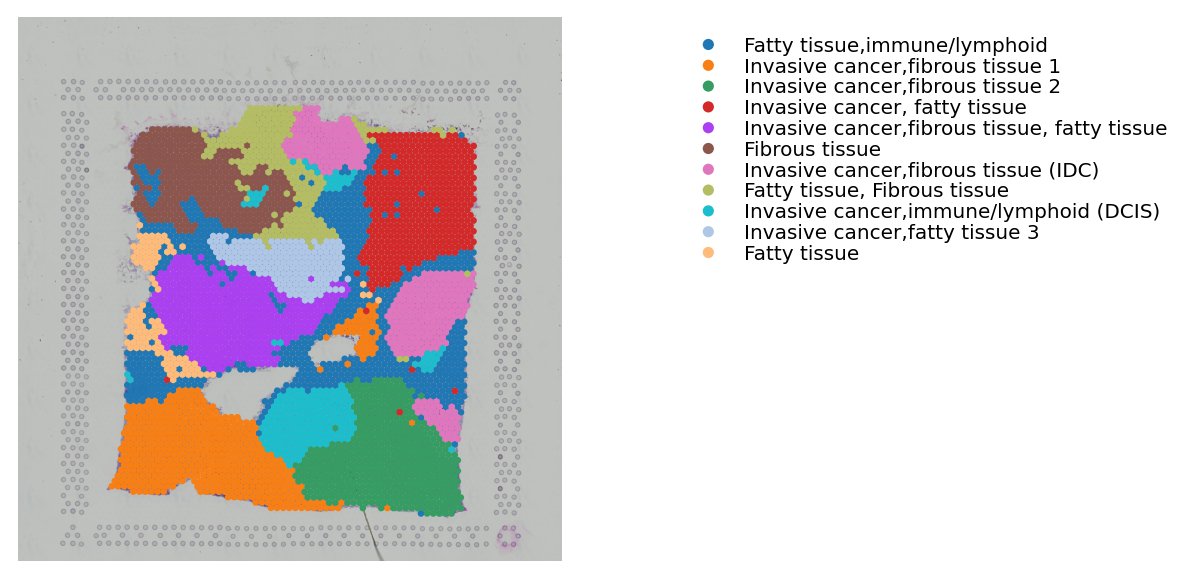

In [5]:
st.add.annotation(data,label_list=['Fatty tissue,immune/lymphoid',
                                   'Invasive cancer,fibrous tissue 1',
                                   'Invasive cancer,fibrous tissue 2',
                                   'Invasive cancer, fatty tissue',
                                   'Invasive cancer,fibrous tissue, fatty tissue',
                                   'Fibrous tissue',
                                   'Invasive cancer,fibrous tissue (IDC)',
                                   'Fatty tissue, Fibrous tissue',
                                   'Invasive cancer,immune/lymphoid (DCIS)' ,
                                   'Invasive cancer,fatty tissue 3',
                                   'Fatty tissue'],
                 use_label="louvain")
st.pl.cluster_plot(data,use_label="louvain_anno",tissue_alpha=1,spot_size=7,show_legend=True)

## 2. Running the global trajectory inference

Here we called global trajectory because it does the same method of trajectory inference in single cell analysis. 

We used PAGA and DPT to perform this step. It also does the function of sub-clustering.

To explore the progression of DCIS-IDC, we choose the root as cluster 6 (Ductal cells area).
Also, We used high resolution image (2000x2000) the the eps parameter should be 100:

In [6]:
import numpy as np
data.uns["iroot"] = np.flatnonzero(data.obs["louvain"]  == str(6))[50]
st.spatial.trajectory.pseudotime(data,eps=100)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


We wrap some plotting function from scanpy to show PAGA and DPT figures

PAGA plot:


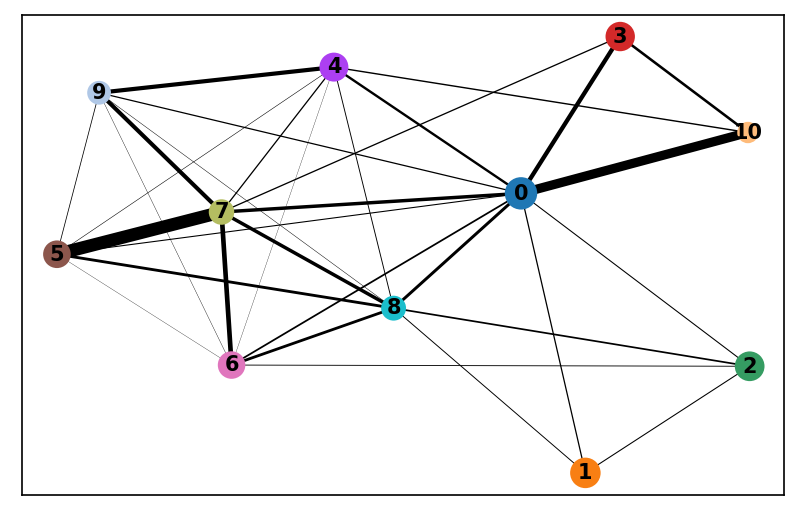

Gene expression (reduced dimension) plot:


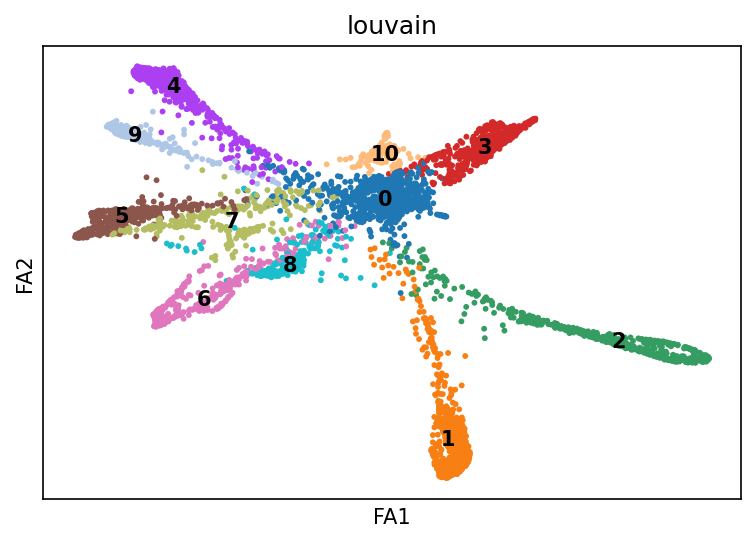

Diffusion pseudotime plot:


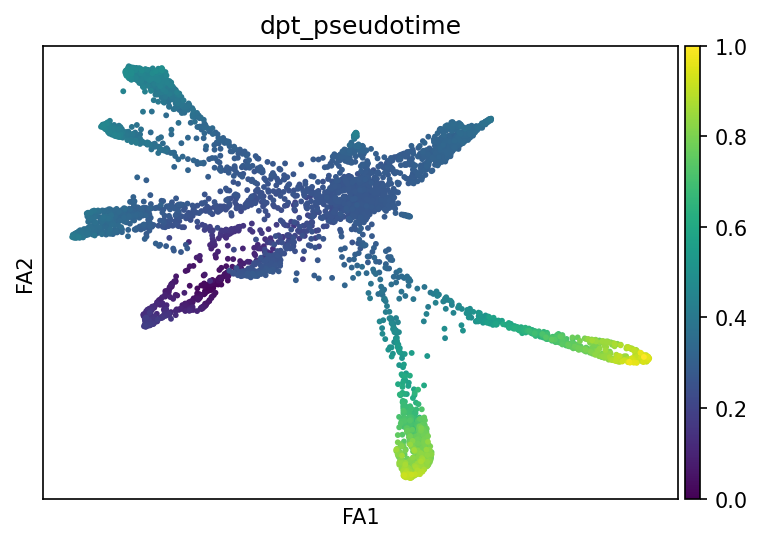

In [7]:
st.pl.non_spatial_plot(data,use_label="louvain",dpi=150)

This is the DPT visualization in tissue morphology

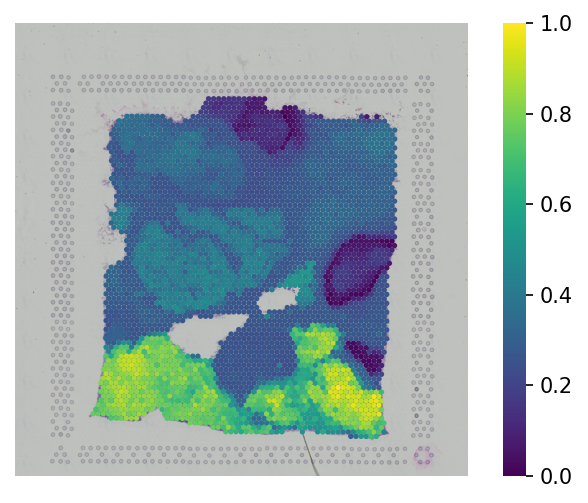

In [8]:
st.pl.trajectory.pseudotime_plot(data,list_cluster="all",show_graph=False,node_alpha=1,tissue_alpha=1,edge_alpha=0.1,node_size=3,dpi=150)

## 3. Running the local trajectory inference

Here, we want to check the intra-DCIS progression.

First, the visualization of sub-clustering results of cluster 6 (DICS) would be showed by:

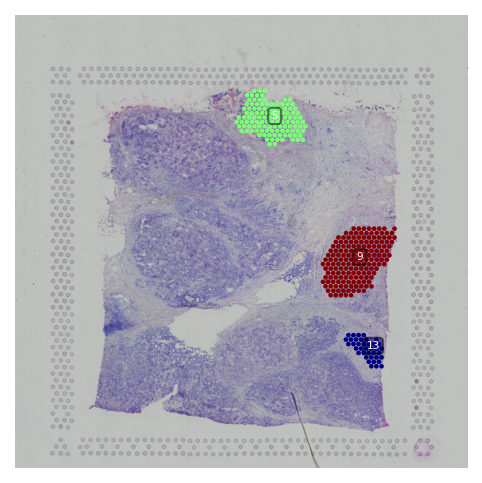

In [9]:
st.pl.subcluster_plot(data,use_label="louvain",cluster=6,tissue_alpha=1,dpi=150)

The local trajectory could be constructed by this function. It calculate the spatio-temporal distance between each pair-wise of sub-clusters.

In [10]:
st.spatial.trajectory.local_level(data,use_label="louvain",cluster=6,w=0.6)

Start construct trajectory for subcluster 6


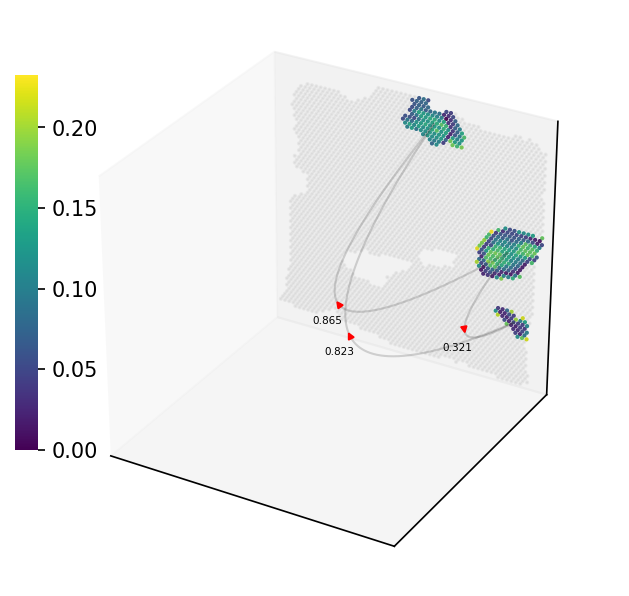

In [11]:
st.pl.trajectory.local_plot(data,use_cluster=6,branch_alpha=0.2,dpi=150,reverse=True)

## Perform pseudo-time-space to reconstruct the progress of DCIS-IDC

In [12]:
st.spatial.trajectory.global_level(data,use_label="louvain",list_cluster=[6,8],w=0.5)

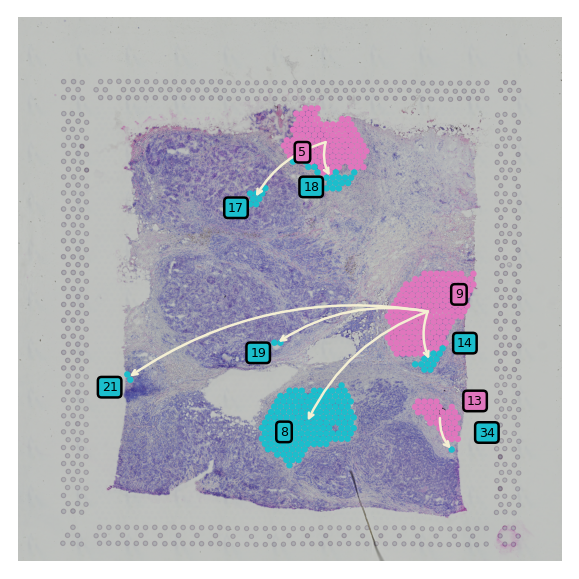

In [13]:
st.pl.cluster_plot(data,use_label="louvain",show_trajectory=True,list_cluster=[6,8],show_subcluster=True,show_legend=False)

C:\Users\duy\stLearn\stlearn\plotting\trajectory\tree_plot.py:166: UserWarning: Attempting to set identical left == right == 1595.13199725 results in singular transformations; automatically expanding.
  ax2.set_xlim(x.min() - ptp_bound[0]*zoom -n,


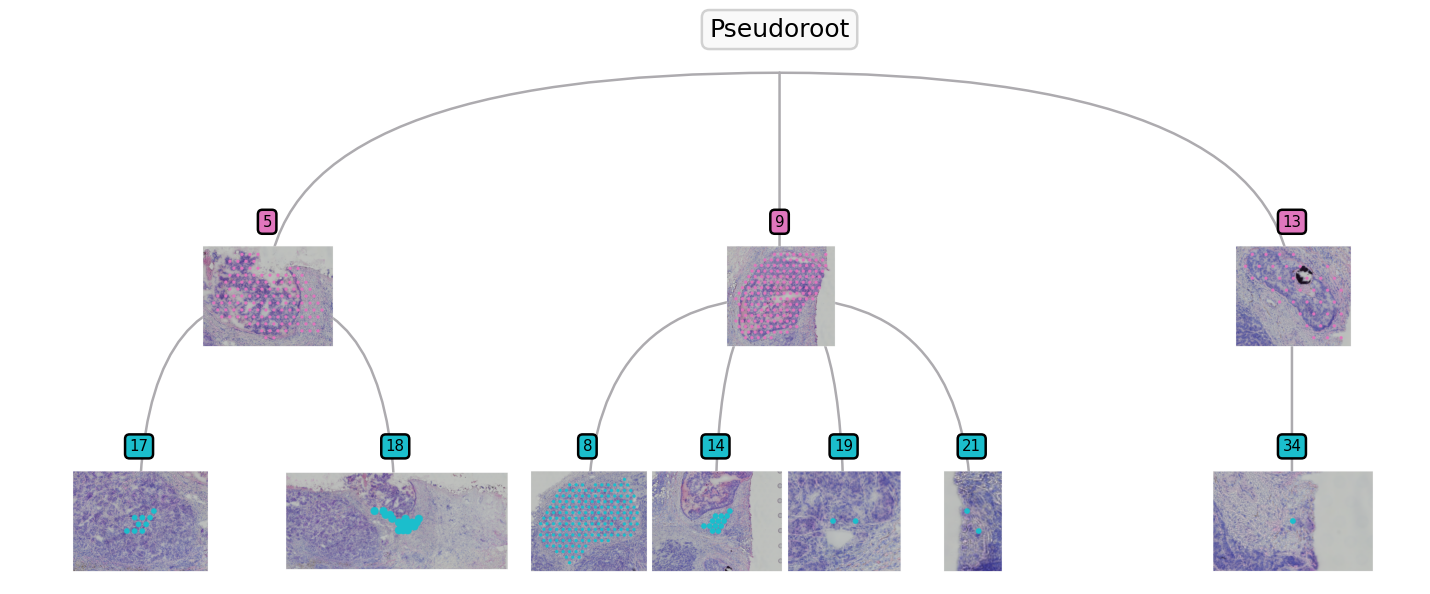

In [14]:
%matplotlib inline
st.pl.trajectory.tree_plot(data)